In [1]:
# imports
from matplotlib import pyplot as plt
import numpy as np
import math
import time

import importlib

import cupy as cp

from mpl_toolkits.mplot3d import Axes3D

from scipy import signal, misc


# Create - Data, Consts, Pars, Lower Bound, Upper Bound

In [2]:
from dipy.data import get_fnames
from dipy.io.image import load_nifti_data, save_nifti, load_nifti
from dipy.io.gradients import read_bvals_bvecs
from dipy.core.gradients import gradient_table

fraw,fbval,fbvec = get_fnames('ivim')

_, affine = load_nifti(fraw)
data = np.float32(load_nifti_data(fraw))
bvals, bvecs = read_bvals_bvecs(fbval, fbvec)
gtab = gradient_table(bvals, bvecs, b0_threshold=0)

data_shape = data.shape
nvoxels = data_shape[0]*data_shape[1]*data_shape[2]
ndata = data_shape[3]
Nelem = nvoxels*ndata

data_flat = np.float32(data.reshape(1, Nelem))
consts = np.float32(np.reshape(np.tile(bvals, nvoxels), (1,Nelem)))

redo_pars_t = False
if redo_pars_t:

    from dipy.reconst.ivim import IvimModel
    ivimmodel = IvimModel(gtab, fit_method='trr')

    ivimfit = ivimmodel.fit(data)

    pars_t = ivimfit.model_params

    save_nifti('pars_dipy.nii', pars_t, affine)

pars_dipy, affine = load_nifti('pars_dipy.nii')
pars_dipy = np.float32(pars_dipy)

lower_bound = np.float32(np.ascontiguousarray(
                np.tile(
                    np.array([np.finfo(np.float32).min / 2, 0.0, 0.0, 0.0]), (data.shape[1],1)).transpose()))

upper_bound = np.float32(np.ascontiguousarray(
                np.tile(
                    np.array([np.finfo(np.float32).max / 2, 1.0, 1.0, 1.0]), (data.shape[1],1)).transpose()))


# Create guess parameters from dipys by convolving

Text(0.5, 1.0, 'data - b=0')

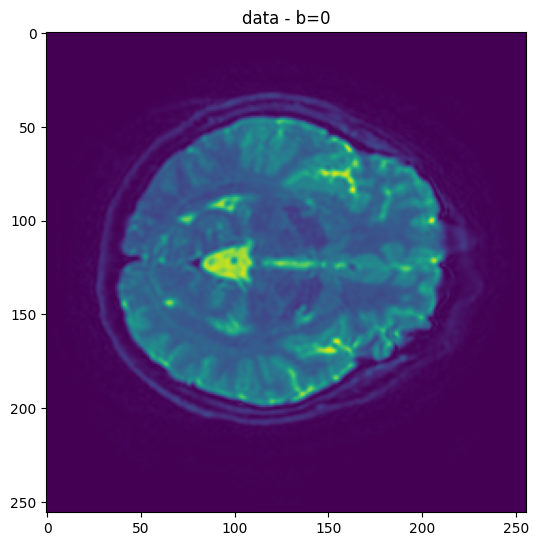

In [3]:
fig1 = plt.figure()
ax1 = fig1.add_axes([0,0,1,1])
ax1.imshow(np.reshape(data, data_shape)[:,:,25,0])
ax1.set_title('data - b=0')

In [4]:

kernel_size = 5
avg_kernel = np.ones((kernel_size,kernel_size))

pars = np.empty(pars_dipy.shape, pars_dipy.dtype)

for i in range(0,pars.shape[2]):
    for j in range(0,4):
        pars[:,:,i,j] = signal.convolve2d(pars_dipy[:,:,i,j], avg_kernel, boundary='symm', mode='same')


In [5]:

def param_printer(pars, slicez=25, print_S0=False, print_f=False, print_D1=False, print_D2=False):

	if print_S0:
		fig1 = plt.figure()
		ax1 = fig1.add_axes([0,0,1,1])
		ax1.imshow(pars[:,:,slicez,0])
		ax1.set_title('S0')

	if print_f:
		fig1 = plt.figure()
		ax1 = fig1.add_axes([0,0,1,1])
		ax1.imshow(pars[:,:,slicez,1])
		ax1.set_title('f')

	if print_D1:
		fig1 = plt.figure()
		ax1 = fig1.add_axes([0,0,1,1])
		ax1.imshow(pars[:,:,slicez,2])
		ax1.set_title('D1')

	if print_D2:
		fig1 = plt.figure()
		ax1 = fig1.add_axes([0,0,1,1])
		ax1.imshow(pars[:,:,slicez,3])
		ax1.set_title('D2')


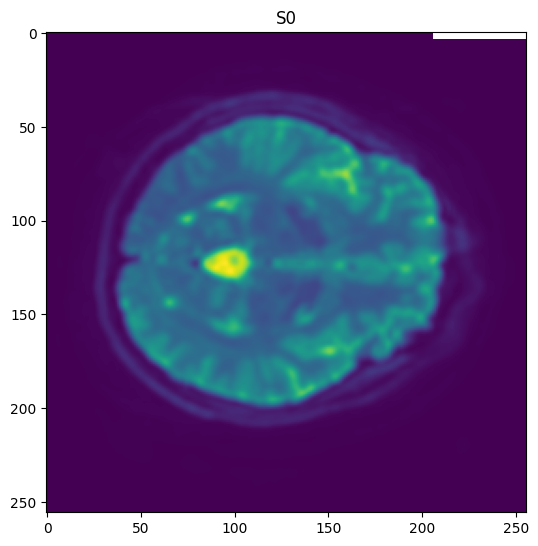

In [6]:
param_printer(pars, print_S0=True)

In [7]:
pars_flat = np.reshape(pars, (4, nvoxels)).copy()

In [8]:
import cuda.lsqnonlin as clsq
importlib.reload(clsq)

expr = 'S0*(f*exp(-b*D_1)+(1-f)*exp(-b*D_2))'
pars_str = ['S0', 'f', 'D_1', 'D_2']
consts_str = ['b']

nchunks = 2
chunk_size = math.ceil(nvoxels / nchunks)

start = time.time()
for i in range(0,nchunks):

    parscu = cp.asarray(pars_flat[:,i*chunk_size:(i+1)*chunk_size].copy())
    constscu = cp.asarray(consts[:,i*chunk_size*ndata:(i+1)*chunk_size*ndata].copy())
    datacu = cp.asarray(data_flat[:,i*chunk_size*ndata:(i+1)*chunk_size*ndata].copy())
    lower_bound_cu = cp.asarray(lower_bound[:,i*chunk_size:(i+1)*chunk_size].copy())
    upper_bound_cu = cp.asarray(upper_bound[:,i*chunk_size:(i+1)*chunk_size].copy())

    solm = clsq.SecondOrderLevenbergMarquardt(expr, pars_str, consts_str, parscu, constscu, datacu, lower_bound_cu, upper_bound_cu, write_to_file = True)
    solm.run(10, 1e-5)

    cp.cuda.stream.get_current_stream().synchronize()
    pars_flat[:,i*chunk_size:(i+1)*chunk_size] = parscu.get()
    del solm

    #time.sleep(5)

cp.cuda.stream.get_current_stream().synchronize()
end = time.time()
print('It took: ' + str(end - start) + ' s')

del parscu
del constscu
del datacu
del lower_bound_cu
del upper_bound_cu


It took: 2.3358092308044434 s


In [9]:
pars_flat_back = np.reshape(pars_flat, pars_dipy.shape)


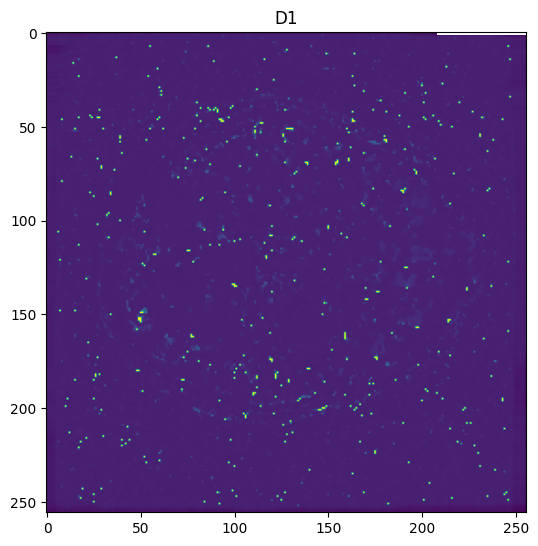

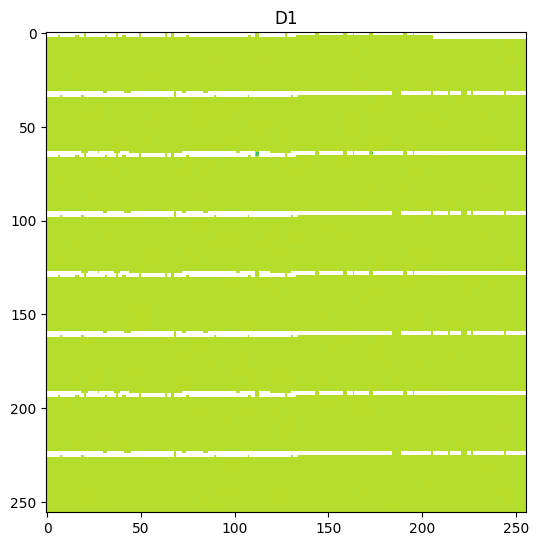

In [10]:
#param_printer(pars, print_S0=True)
param_printer(pars_dipy, print_S0=True)

param_printer(pars_flat_back, print_S0=True)
